# Machine learning with *HyperSpy*: Denoising and decomposition

Tutorial for the **eBEAM2024 school on nano-optics with free electrons**

> Aussois, September 1-13, 2024

**Table of Contents:**

- [EELS - Blind source separation](#EELS---Blind-source-separation)
- [Singular Value Decomposition (SVD)](#Singular-Value-Decomposition-(SVD))
- [Non-negative Matrix Factorisation (NMF)](#Non-negative-Matrix-Factorisation-(NMF))
- [Independent component analysis (ICA)](#Independent-component-analysis-(ICA))

In [1]:
# Use '%matplotlib widget' in JupterLab and '%matplotlib notebook' in JupyterNotebook for interactive inline functionality (e.g. on binder)
# For pop-up window plots on your local computer, use '%matplotlib tk' or '%matplotlib qt' instead
%matplotlib widget

import numpy as np
import hyperspy.api as hs

In [2]:
hs.__version__

'2.1.1'

In [3]:
np.__version__

'2.0.1'

## EELS - Blind source separation

In this example, we will examine a low-loss EELS dataset acquired on a silver nanoparticle (a right bipyramid). Silver and other plasmonic materials exhibit <i>surface plasmon resonance modes</i> at specific energies each with corresponding spatial distributions of the energy loss probability. The dataset used in this tutorial has been [published](https://pubs.acs.org/doi/10.1021/acsphotonics.5b00421), making use of a similar analysis approach.

<b><i>Blind source separation</i></b> refers to a family of techniques seeking to use multivariate statistics or machine learning methods to automatically or algorithmically unmix multiple, unknown 'sources' contributing to a hyperspectral dataset.

Briefly, the dataset $\mathbf{X}$ defined over $\mathbf{R} = (x,y)$ and energy loss $\mathbf{E}$ can be considered as the matrix multiplication of $k$ sources:

$\mathbf{X}_{\mathbf{R} \times \mathbf{E}} = \mathbf{A}_{\mathbf{R} \times k} \mathbf{B}^{T}_{k \times \mathbf{E}}$  (Eq. 1)

For each source $k$ there is a map or image $A_{\mathbf{R}}$ and spectrum vector $\mathbf{B}_{\mathbf{E}}$. Now, in principle any dataset could, in the extreme or limiting case, have a different source $k$ at each pixel, such that the number of pixels $N_{\mathbf{R}}$ is equal to the number of source $N_{k}$, i.e. $N_{\mathbf{R}} = N_{k}$. If, however, the number of sources $k$ is small, then the data can also be represented without significant loss by a set of sources $k << N_{\mathbf{R}}$.

In many physical situations, where often there are only a handful of sources of signals, such as surface plasmon resonance modes, compositions or bonding types that give rise to a limited set of peaks or other characteristic features in a spectrum, this treatment is well justified.

Consequently, there are several beneficial outcomes in treating the data this way:

1. <b>Dimensionality reduction</b> - identifing $k << N_{\mathbf{R}}$ sources means a simplified representation of $\mathbf{X}(\mathbf{R}=(x,y),\mathbf{E})$ data into a set of separate images (maps) and their corresponding spectra. Where these can be idenfied with physically meaningful sources (note, physicality is <i>not></i> guaranteed by statistical or algorithmic methods) then the separated features may be result we are after in carrying out the experiment.

2. <b>Denoising</b> - carrying out a matrix decomposition can be used to split the signal sources from the noise sources by identifying the small number of signal sources $k << N_{\mathbf{R}}$ in the presenece of smaller scatter (small contributions to the variance from noise).

3. <b>Data treatment agnostic to feature shape</b> - whereas peak fitting assumes <i>a priori</i> knowledge of the peak shape or function type for fitting, blind source separation does not impose any specific spectral feature shape. Complex or unknown peak or feature shapes can be recovered as well as combining multiple peaks or features (e.g. EELS fine structure) that originate from a common source and therefore change together in synchrony throughout a dataset (rather than requiring multiple functions to fit a single signal source).

Without going into too much detail here, machine learning algorithms in HyperSpy seek a numerical or numerical approximation to the solution outlined in Eq. 1. See also the [HyperSpy documentation](https://hyperspy.org/hyperspy-doc/v2.0/user_guide/mva/index.html) and underpinning references for more details.

### Loading the EELS spectrum image

First we will load the dataset, a spectrum image we will denote `s`.

For this tutorial, the data has already been processed in three key ways:

1. <b>Zero loss peak alignment</b>

I would often carry out this procedure in two steps, first selecting a signal range less than the full energy loss window (here set with the argument `signal_range=(0.,5.)`) to reduce the large-scale wobble or offset from 0 eV energy loss at pixel precision (`subpixel = False`):

`s.align_zero_loss_peak(signal_range=(0.,5.),subpixel=False)`

Then, I would carry out a subpixel precision refinement over a computationally more efficient reduced signal range:

`s.align_zero_loss_peak(signal_range=(-0.2,0.2),subpixel=True)`

2. <b>Spikes removed</b> - as for CL data, X-rays and other high energy photons can produce spikes on electron detectors. The `spikes_removal_tool()` can be used to remove these as for CL data.


3. <b>Data cropping</b> - I have cropped the energy loss range to the region of interest for further analyis:

`s.crop_signal(0.5,5.)`

The navigation axes can also be cropped using:

`s.crop(0,start,stop)`
and
`s.crop(1,start,stop)` for selected values of start and stop (e.g. in pixels)

4. <b>Minimum value set to 0</b>. For some of the blind source separation algorithms, it is necessary to ensure all data is non-negative ($\geq 0$). First, let's check what the minimum value of the data array is. Note, that for `s` the `EELSSpectrum` the data is stored in a NumPy array that can be access as `s.data`. We can calculate the minimum value across all axes of a NumPy array using

`s.data -= s.data.min()`

And we can adjust all values such that the minimum is 0 by

`s.data -= s.data.min()`

Note the syntax below is equivalent to:

`s.data = s.data - s.data.min()`

In [4]:
s = hs.load('data/Bipyramid_EELS_zlp_aligned_spikes_removed_rebinned.hspy')

### Check the data

Let's check what the dataset looks like. It should show as having navigation dimensions (260,239) and a signal dimension of 900.

In [5]:
s

<EELSSpectrum, title: EELS Spectrum Image (dark ref corrected), dimensions: (130, 119|450)>

For reference, we can compare against known signal types, in this case the `EELSSpectrum` type from `exspy` should be recognised on loading. If you do not see `exspy` package types on running the line below, part of the installation may not be completed for handling EELS data with HyperSpy.

In [6]:
hs.print_known_signal_types()

signal_type,aliases,class name,package
CL_SEM,"CLSEM, cathodoluminescence SEM",CLSEMSpectrum,lumispy
CL_STEM,"CLSTEM, cathodoluminescence STEM",CLSTEMSpectrum,lumispy
CL,"CLSpectrum, cathodoluminescence",CLSpectrum,lumispy
DielectricFunction,dielectric function,DielectricFunction,exspy
EDS_SEM,,EDSSEMSpectrum,exspy
EDS_TEM,,EDSTEMSpectrum,exspy
EELS,TEM EELS,EELSSpectrum,exspy
EL,"ELSpectrum, electroluminescence",ELSpectrum,lumispy
Luminescence,LuminescenceSpectrum,LumiSpectrum,lumispy
Transient,"TRLumi, TR luminescence, time-resolved luminescence",LumiTransient,lumispy


We can also inspect the `axes_manager` for more details:

In [7]:
s.axes_manager

Navigation axis name,size,index,offset,scale,units
x,130,0,0.0005105563905090094,0.0020422255620360374,µm
y,119,0,0.0005105563905090094,0.0020422255620360374,µm
Signal axis name,size,,offset,scale,units
Energy loss,450,,0.5008198310974037,0.009999999776482582,eV


### Pre-checks

Let's double check the minimum value is non-negative:

In [8]:
s.data.min()

np.float32(0.0)

### Plotting

Next, let's plot the signal to have a closer look. A pair of windows should appear (may take a few moments), consisting of an overview image (summed intensity along the energy loss axis at each probe position in a STEM scan) and the corresponding spectrum for a single active pixel.

Provided interactive plotting is enabled, you can drag the red square (use <b>Shift</b> and <b>'+'</b> keys pressed at the same time to enlarge the red square marking the active pixel if it is hard to grab with your mouse or otherwise difficult to see).

Consider moving to different corners just outside of the projected image of the right bipyramid or to the edges to see how the spectrum changes in different locations.

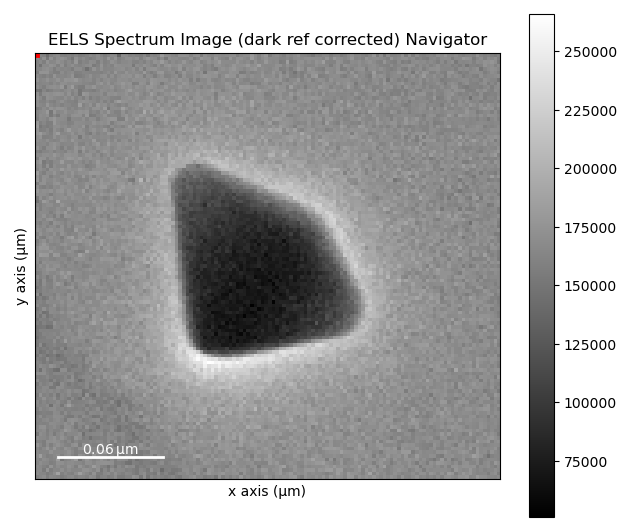

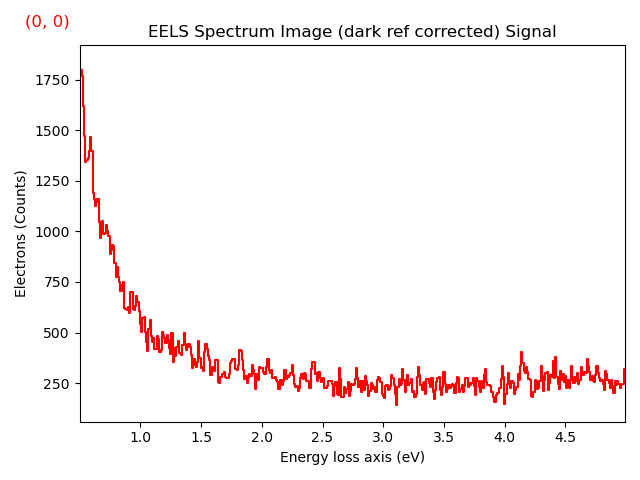

In [9]:
s.plot()

## Singular Value Decomposition (SVD)

First, we carry out an SVD decomposition. This is akin to a principal component analyis approach in delivering a decomposition with orthogonal vectors that can be sorted by their contribution to the signal variance for statistical evaluation.

Note, for EELS it is important to account for the Poissonian noise properties (electron counts). HyperSpy implements a renormalisation for `normalize_poissonian_noise=True`.

In [10]:
s.decomposition(normalize_poissonian_noise=True,algorithm='SVD')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


### Scree plot analysis

The SVD and PCA-like algorithms can be used in themselves for dimensionality reduction and denoising. However, the vectors can be positive and negative and therefore include correlations as well as anti-correlations between different spectral features. The resulting spectra (`factors` in HyperSpy) and images (`loadings` in HyperSpy) can be difficult to interpret. 

However, the decomposition is <i>very useful</i> in assessing how many components (or sources) may be required to adequately describe the dataset.

By sorting a full set of $k = N_{\mathbf{R}}$ sources by their contribution to the signal variance (proportion of the variance), we can see that only a subset actually dominate the variance. The others are minor fluctuations abou the mean, i.e. noise. Such a plot is termed a <b>Scree plot</b>. Each source $k$ is represented in a Scree plot by a single value (the proportion of the variance it represents)

An ideal Scree plot will show a few values well separated from a 'flat line' baseline of small contributions. The plot below generally exhibits this type of 'L' shape, though it also exhibits a typical experimental phenomenon: There is not sharp cut-off and the contributions gradually fade to the background 'flat line'. When the signal-to-noise ratio is finite and some sources or signals are weak, the distinction between signal and noise is not always so well defined. Nevertheless, the Scree plot gives us a <i>practical estimate</i> of the number of components or sources to consider as important.

Below, we plot the first $k \leq 30 $ components (not the full $k = N_{\mathbf{R}}$ - you can change `n = 30` below if you would like to see more of them).

How many sources would you identify above the 'flat line' (noise)?

<Axes: title={'center': 'EELS Spectrum Image (dark ref corrected)\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

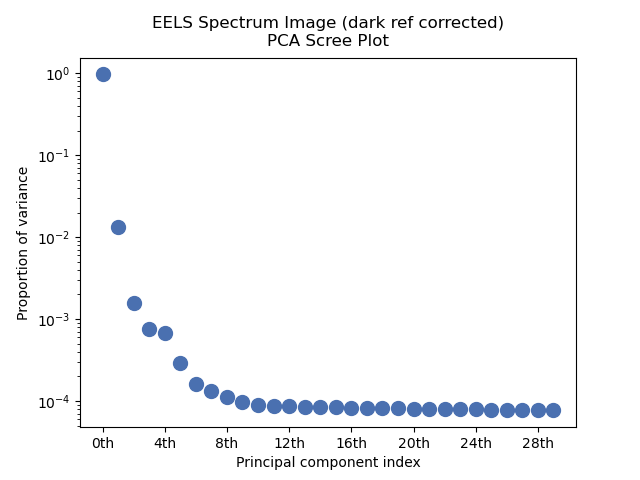

In [11]:
s.plot_explained_variance_ratio(n = 30)

I count at least 7 that are above the line - this may be a useful starting point for iteratively exploring how decompositions can be used to take apart the dataset.

## Non-negative Matrix Factorisation (NMF)

To overcome a key limitation of SVD (the complexity arising from correlations and anticorrelations and positive and negative values in images and spectra), an alternative to SVD is to impose non-negativity as the primary constraint instead of pursuing an orthogonal vector representation. A second constraint is implemented through the selection of a finite number of sources, usually a small number compared to the total number of pixels in a spectrum image ($k << N_{\mathbf{R}}$)

The downside is that the vectors will not be constrained mathematically or statistically in the same way, but the resulting features will readily interpretable. There are a number of conditions where NMF <i>does</i> deliver guarantees (see [Donoho and Stodden](https://www.cs.cornell.edu/courses/cs6241/2020sp/readings/Donoho-Stodden-2003-separable.pdf), for example) but these are often only partially satisfied in EELS in practice. Nevertheless, NMF decompositions have been incredibly useful from a practical standpoint in EELS. Notably, in plasmonics NMF decompositions can be very effectively validated using simulations (e.g. boundary element method calculations). Validation of NMF results is of central importance.

Here, I have iteratively explored a range of $N_{k}$ (across $k = 6, 7, 8, 9, ...$). Notably, NMF generally exhibits a tendency to start to split components when $N_{k}$ is too large, giving rise to additional peaks that are asymmetric 'halves' of otherwise symmetric spectral features. As such, by increasing from a number of components that is too small it is possible to track the addition of new signals up to the point where these begin to be split or where additional featureless maps appear.

Using this type of approach, <b><i>I have found 8-9 components to be an effective decomposition.</i></b> 

Note, with the default parameters settings you will see a warning that the algorithm has not converged at 200 iterations). Several parameters like `tol=` or `max_iter=` can be passed as keyword arguments to modify the algorithm, but for a practically useful and illustrative result these are not useful here. Note also the HyperSpy version is not identical to that reported in [2015](https://pubs.acs.org/doi/10.1021/acsphotonics.5b00421) so while results in this tutorial are similar they are not identical to the published decomposition results.

In [12]:
s.decomposition(normalize_poissonian_noise=True,algorithm='NMF',output_dimension=9)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=9
  centre=None
scikit-learn estimator:
NMF(n_components=9)


/home/jonas/.conda/envs/hyperspy-stable/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Plot the NMF results

There are dedicated plotting commands for the decomposition output. The most flexible plots the multi-dimensional set of `loadings` and `factors` together:

The widget matplotlib backend is not compatible with the traitsui GUI elements. For more information, read http://hyperspy.readthedocs.io/en/stable/user_guide/getting_started.html#possible-warnings-when-importing-hyperspy.


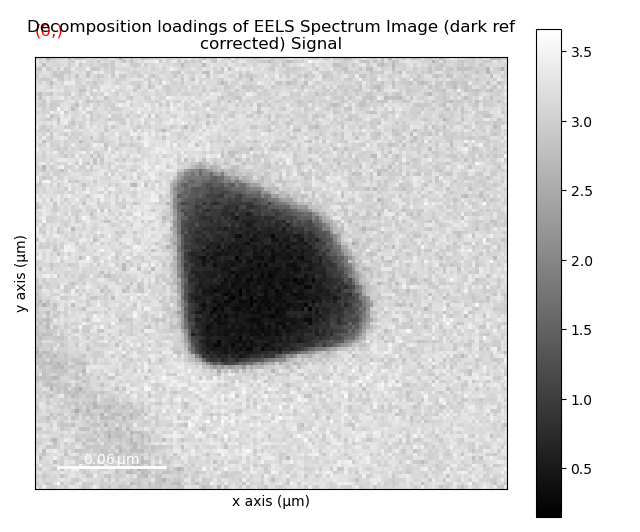

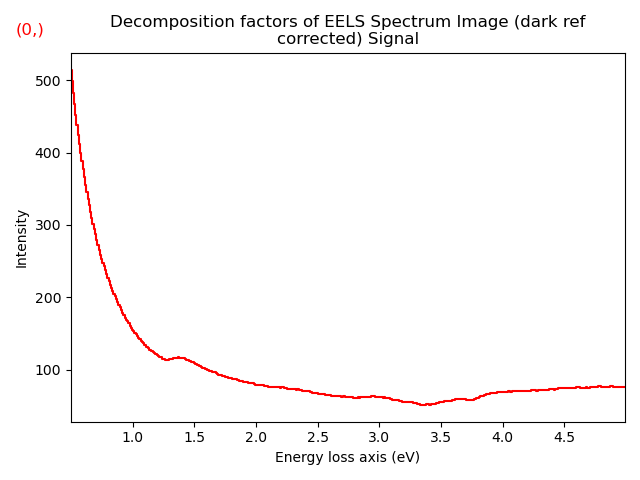

In [13]:
s.plot_decomposition_results()

We can also plot either the images or maps (`loadings`) in isolation:

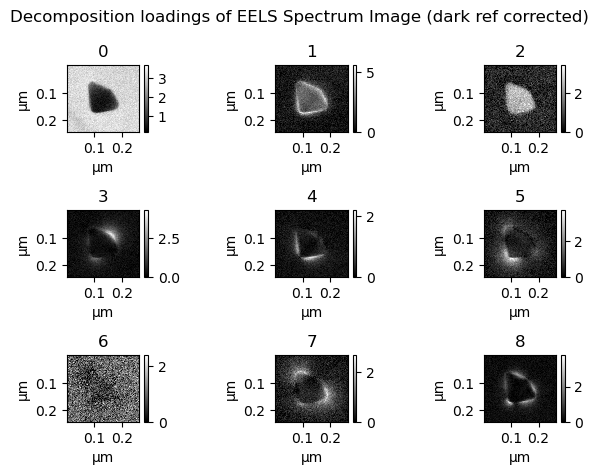

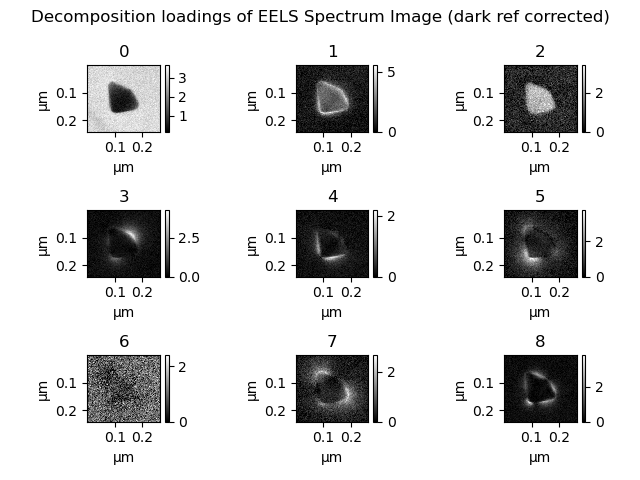

In [14]:
s.plot_decomposition_loadings()

Or just the spectral vectors (`factors`) in isolation:

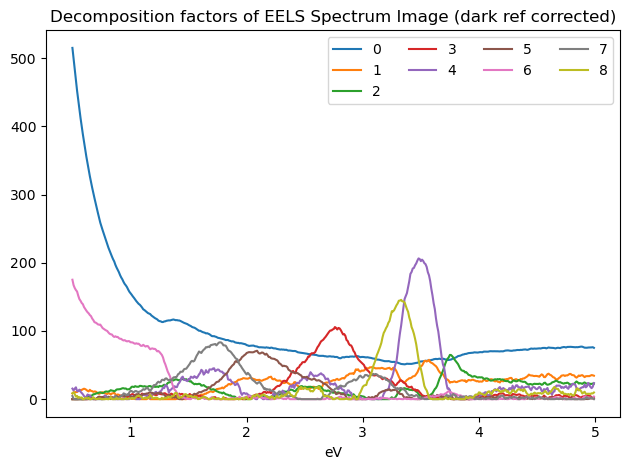

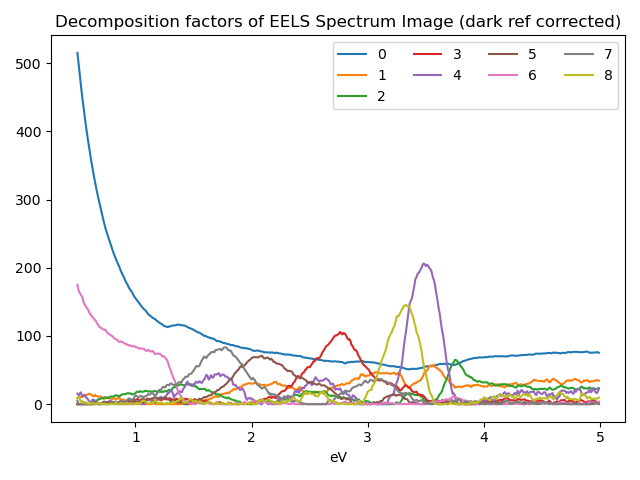

In [15]:
s.plot_decomposition_factors()

## Independent component analysis (ICA)

If of interest, an alternative algorithm, can also be explored. ICA uses the central limit theorem to take the orthogonalised vectors from a PCA or SVD calculation and find the a solution that maximises their statistical independence.

In HyperSpy, this can be carried out using similar, albeit slightly different, syntax:

1. First re-run the SVD decomposition:

`s.decomposition(normalize_poissonian_noise=True,algorithm='SVD')`

2. Then run:

`s.blind_source_separation(number_of_components=9)`

3. For plotting:

`s.plot_bss_results()`

`s.plot_bss_loadings()`

`s.plot_bss_factors()`